# Cox-Prop Hazards Analysis using scikit-survival - WHAS500

In [24]:
# Core libraries
import pandas as pd 
import numpy as np 
import seaborn as sb 
import matplotlib.pyplot as plt

# Survival analysis and datasets 
from sklearn import set_config
from sklearn.pipeline import make_pipeline 
from sksurv.datasets import load_whas500
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import train_test_split
from sksurv.metrics import (concordance_index_censored, cumulative_dynamic_auc, integrated_brier_score)
from sksurv.preprocessing import OneHotEncoder #Needs to be from the scikit-surv package
from sksurv.column import standardize #Note this is a method not a class
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.functions import StepFunction

SEED = 20221228

### Load in dataset 

In [30]:
# scikit-survival y has two fields (outcome and follow-up time)
    ## Note: If survival was True, then the column denoting the event indicator will be boolean and survival times will be float
    ##       If attr_labels contains None, y is set to None.
whas500_X, whas500_y = load_whas500()
types_whas500X = whas500_X.dtypes
types_whas500Y = whas500_y.dtype

# Center and scale all numeric columns
whas500_X = standardize(whas500_X) 

X_train, X_test, y_train, y_test = train_test_split(whas500_X, whas500_y, test_size=0.25, stratify=whas500_y["fstat"], random_state=SEED)

### Train model 

In [31]:
# Note that the categorical features need to be encoded else errors get thrown when trying to predict (model still fits for some reason)
    ## Standardization isn't a class compatible with pipelines
coxPH = make_pipeline(OneHotEncoder(), CoxPHSurvivalAnalysis())
coxPH.fit(X_train, y_train)

#Generate predictions 
coxPH_risks = coxPH.predict(X_test)

/usr/local/lib/python3.9/site-packages/sksurv/column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():
/usr/local/lib/python3.9/site-packages/sksurv/column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():


### Evaluate model

#### Discrimination 

In [34]:
# Overall C-index 
 ## Note: Harrell’s concordance index is known to be biased upwards if the amount of censoring in the test data is high.
 ##       Uno et al proposed an alternative estimator of the concordance index that behaves better in such situations (inverse prob of censor weights)
 ##       Implemented as concordance_index_ipcw

C_Index = concordance_index_censored(y_test['fstat'], y_test['lenfol'], coxPH_risks)[0]
C_Index.round(3)

0.759

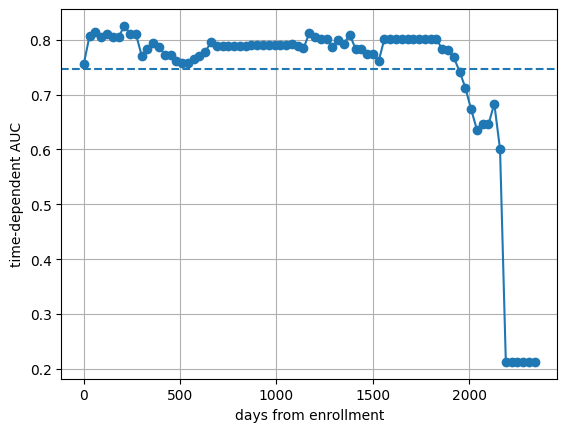

In [35]:
# Time dependent C-index
times = np.arange(1, 2350, 30) # The follow up times in the test set are between 1 and 2350 days 
coxPH_auc, coxPH_mean_auc = cumulative_dynamic_auc(y_train, y_test, coxPH_risks, times)

plt.plot(times, coxPH_auc, marker="o")
plt.axhline(coxPH_mean_auc, linestyle="--")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.grid(True)

#### Calibration

In [36]:
# Compute integrated Brier scores between the 10th and 90th percentile of observed datapoints in the test set
lower, upper = np.percentile(y_test["lenfol"], [10, 90])
times_bounded = np.arange(lower, upper + 1)

cph_surv_prob = np.row_stack([fn(times_bounded) for fn in coxPH.predict_survival_function(X_test)])

# Compare against a random model and the base Kaplan-Meier function which doesn't use any predictors 
random_surv_prob = 0.5 * np.ones((y_test.shape[0], times_bounded.shape[0]))

km_func = StepFunction(*kaplan_meier_estimator(y_test["fstat"], y_test["lenfol"]))
km_surv_prob = np.tile(km_func(times_bounded), (y_test.shape[0], 1))

# The Brier score calculator needs survival times for training data to estimate the censoring distribution
score_brier = pd.Series([integrated_brier_score(y_train, y_test, prob, times_bounded)
                        for prob in (cph_surv_prob, random_surv_prob, km_surv_prob)],
                        index=["CPH", "Random", "Kaplan-Meier"],name="IBS")

score_brier.round(3)

/usr/local/lib/python3.9/site-packages/sksurv/column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():


CPH             0.177
Random          0.249
Kaplan-Meier    0.220
Name: IBS, dtype: float64